In [1]:
#import necessary libraries for regression analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import scipy.stats as stats
from sklearn.model_selection import train_test_split

import pylab
from modelCustomFunctions import create_ols, check_resid_distribution, check_features_vif, get_low_pval_features

### Custom Functions ###

In [2]:
df_preprocessed = pd.read_csv('Project2datacleaned', index_col=0)
df_preprocessed.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,renovated,grade_binned,floors_binned
0,221900.0,3,1.00,1180,5650,0.0,0.0,3,1180,0.0,1955,98178,1340,5650,0,1,0
1,538000.0,3,2.25,2570,7242,0.0,0.0,3,2170,400.0,1951,98125,1690,7639,0,1,1
2,180000.0,2,1.00,770,10000,0.0,0.0,3,770,0.0,1933,98028,2720,8062,0,0,0
3,604000.0,4,3.00,1960,5000,0.0,0.0,5,1050,910.0,1965,98136,1360,5000,0,1,0
4,510000.0,3,2.00,1680,8080,0.0,0.0,3,1680,0.0,1987,98074,1800,7503,0,1,0


### Train-Test-Split

In [3]:
train, test = train_test_split(df_preprocessed, test_size=0.2, random_state=42)

In [4]:
print(len(train), len(test))

13449 3363


In [5]:
#Build baseline model
X = train.drop('price', axis=1)
formula = 'price~' + '+'.join(X.columns)

In [6]:
baseline = ols(formula=formula, data=train).fit()

In [7]:
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     489.1
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:39:03   Log-Likelihood:            -1.7520e+05
No. Observations:               13449   AIC:                         3.504e+05
Df Residuals:                   13432   BIC:                         3.506e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.112e+07   1.98e+06    -10.654      0.000    -2.5e+07   -1.72e+07
bedrooms      -2.197e+04   1528.129    -14.376      0.000    -2.5e+04    -1.9e+04
bathrooms      3.208e+04   2475.212     12.962      0.000    2.72e+04    3.69e+04
sqft_living      84.0093     16.284      5.159      0.000      52.090     115.929
sqft_lot          0.1050      0.043      2.434      0.015       0.020       0.190
waterfront     5.433e+04    2.5e+04      2.172      0.030    5290.922    1.03e+05
view           8591.2480   1963.987      4.374      0.000    4741.557    1.24e+04
condition      1.084e+04   1623.837      6.676      0.000    7658.500     1.4e+04
sqft_above      -34.6997     16.259     -2.134      0.033     -66.570      -2.829
sqft_basement    -8.0923     16.195     -0.500      0.617     -39.838      23.653
yr_built      -1427.1982     49.555    -28.800      0.000   -1524.333   -1330.064
zipcode         244.5899     19.931     12.272      0.000     205.522     283.657
sqft_living15    70.8428      2.800     25.301      0.000      65.355      76.331
sqft_lot15       -0.0652      0.058     -1.116      0.264      -0.180       0.049
renovated      6204.3629   5936.815      1.045      0.296   -5432.630    1.78e+04
grade_binned   8.423e+04   3222.144     26.141      0.000    7.79e+04    9.05e+04
floors_binned  4.876e+04   2226.928     21.894      0.000    4.44e+04    5.31e+04
==============================================================================
Omnibus:                      284.638   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.084
Skew:                           0.205   Prob(JB):                     1.08e-45
Kurtosis:                       2.551   Cond. No.                     2.09e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
features = df_preprocessed.columns.drop('price')

def check_homoskedasticity(model, df, target : "", features):
    
    """Input: 
    model: an sm.OLS model  
    df: a data frame
    target : a string 
    features: the features of the model 
    
    Retrun: 
    True if 
    False  
    Prints out P-value and F-statistic
    ------------------------
    Uses the Breusch–Pagan test. If p-value is below 0.05, then 
    the null hypothesis of homoskedasticity is rejected and 
    heteroskedasticity is assumed.
    """ 
    
    #Plot scatter plot
    y_hat = df[target] - model.predict(df[features])
            
    plt.scatter(model.predict(df[features]), y_hat, alpha = 0.2)
    plt.plot(model.predict(df[features]), [0 for i in range(len(df))])
    plt.show()

    #run Pegan test
    _, pval, _, f_pval = diag.het_breuschpagan(model.resid, model.model.exog)
    
    print('-'*50)
    print('The P-value is: {:.2}'.format(pval))
    print('The F-statistic is {:.2}'.format(f_pval))
    print('-'*50)
    
    if pval >= 0.05:
    
        print("The p-value is above 0.05, thus we fail to reject the null hypothesis of homoskedasticity")
        return True

    return False

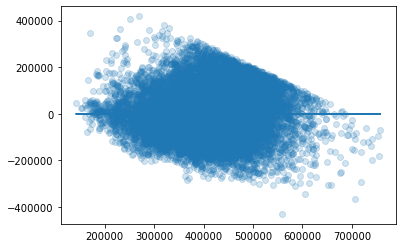

--------------------------------------------------
The P-value is: 2.2e-31
The F-statistic is 1.3e-31
--------------------------------------------------


False

In [9]:
#Check for Homoskedasticity
check_homoskedasticity(baseline, train, "price", features)

In [10]:
#Check for Multicollinearity 
check_features_vif(train, "price")

,VIF Factor,features
0,28.2,bedrooms
1,28.5,bathrooms
2,1071.1,sqft_living
3,2.6,sqft_lot
4,1.1,waterfront
5,1.2,view
6,34.1,condition
7,820.4,sqft_above
8,55.6,sqft_basement
9,9715.1,yr_built


['sqft_living',
 'condition',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'zipcode',
 'sqft_living15']

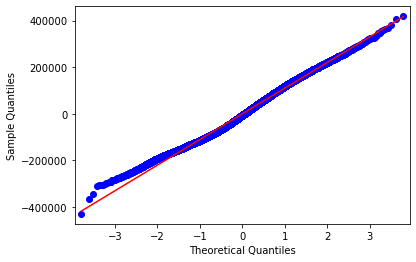

The mean of the residuals is: 4.5e-07. The closer to 0, the better.


In [11]:
#Check for Normality 
check_resid_distribution(baseline)

In [12]:
#Which features have p-values below 0.05 in our summary
get_low_pval_features(baseline)

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'view',
 'condition',
 'sqft_above',
 'yr_built',
 'zipcode',
 'sqft_living15',
 'grade_binned',
 'floors_binned']

### Model 1: Log Transform Variables

Steps to improve the model:

1. We noticed there's heteroscedasticity in our data, we will attempt to fix that by log transforming highly skewed variables, such as **sqft_living**.

2. We also noticed that there's some among our features. To improve on that, we will **drop some features with a high variance inflation factor**: 

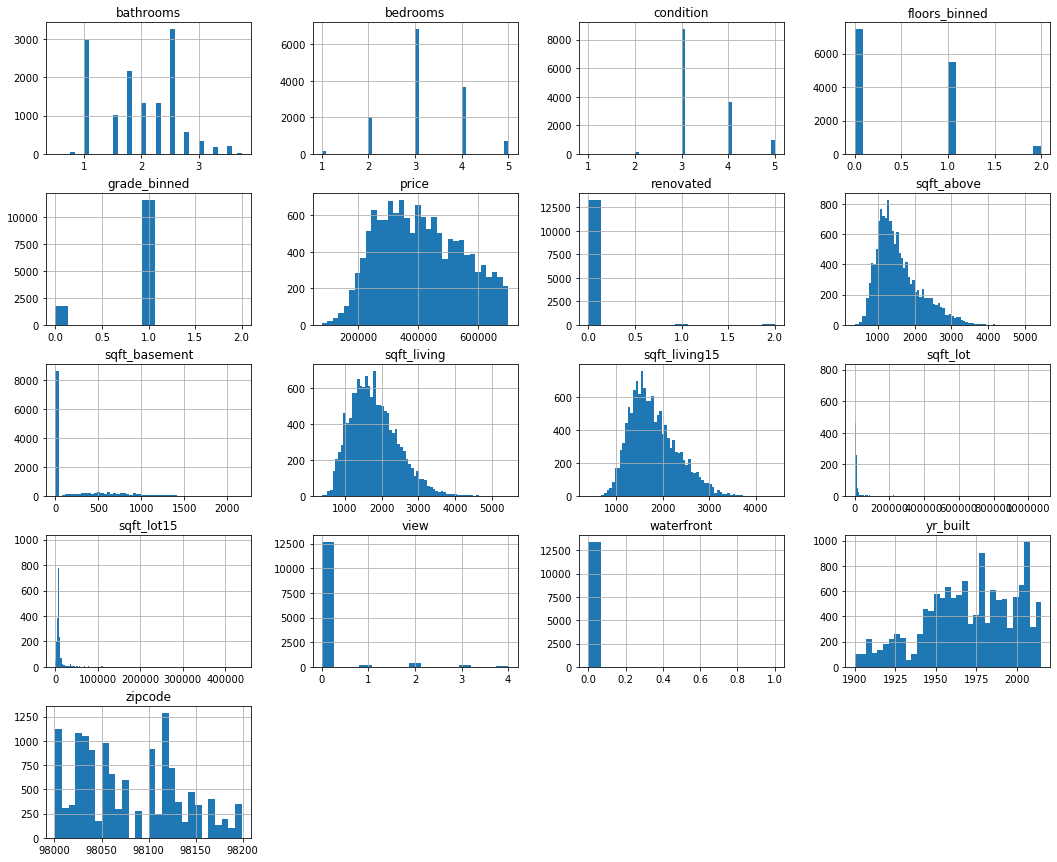

In [13]:
#explore variables for skewness 
train.hist(figsize=(18,15), bins='auto');

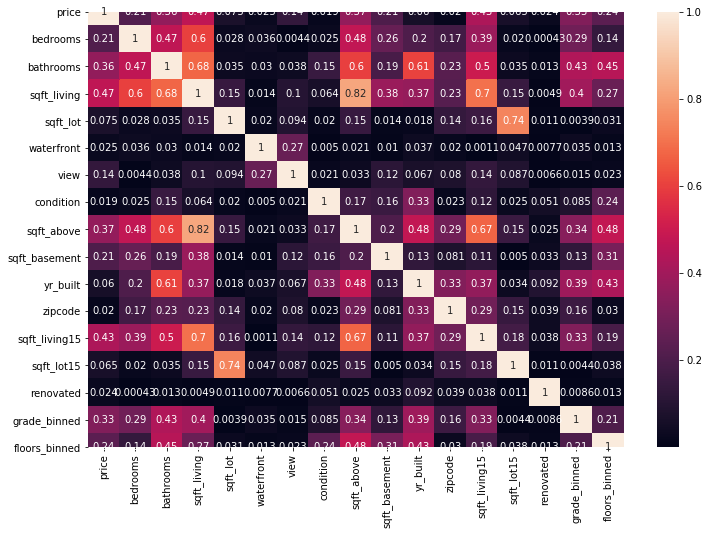

In [14]:
#explore features with high correlation 
corr = train.corr().abs()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True)
plt.show()

We see that sqft_living is highly correlated with sqft_above and sqft_living15, which we deem less relevant to our prediction. We will remove these two from the feature set. In addition, we'll log transform sqft_living.

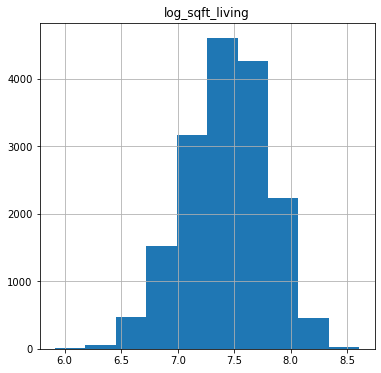

In [15]:
data_log = pd.DataFrame([])
data_log['log_sqft_living'] = np.log(df_preprocessed['sqft_living'])
data_log.hist(figsize  = [6, 6]);

In [17]:
df_preprocessed = df_preprocessed.drop(columns = ["sqft_above", "sqft_living15", 'sqft_lot15', 'sqft_basement','sqft_living' ])

In [18]:
df_model2 = pd.concat([df_preprocessed, data_log], axis=1)

In [19]:
train2, test2 = train_test_split(df_model2, test_size=0.2, random_state=42)

In [20]:
create_ols(train2)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     554.3
Date:                Thu, 19 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:40:19   Log-Likelihood:            -1.7559e+05
No. Observations:               13449   AIC:                         3.512e+05
Df Residuals:                   13436   BIC:                         3.513e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.778e+07      2e+06     

In [ ]:
#Adding dummies to categorical variables
floors_dummies = pd.get_dummies(df['floors_binned'], prefix='floors_binned', drop_first=True)
view_dummies = pd.get_dummies(df['view'], prefix='view', drop_first=True)
grade_dummies = pd.get_dummies(df['grade_binned'], prefix='grade_binned', drop_first=True)
condition_dummies = pd.get_dummies(df['condition'], prefix='condition', drop_first=True)

df_preprocessed = df.drop(['floors_binned', 'view', 'grade_binned', 'condition'], axis=1)
df_preprocessed = pd.concat([df_preprocessed, floors_dummies, view_dummies, grade_dummies, condition_dummies], axis=1)
df_preprocessed.info()

In [ ]:
#Rename columns that contain '.' so that they will run properly through our regression model later
df.columns = df.columns.str.replace('.','_')

In [ ]:
#Should we be removing floors and grade? The binned variables?

In [ ]:
#new feature: age

#df_preprocessed['age'] = df_preprocessed['yr_built'].apply(lambda x: 2015 - x)


##X = df_model2.drop("price", axis=1)
##Y = df_model2[["price"]]  
##X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= .20, random_state = 1 )
    
